In [2]:
librarian::shelf(tidyverse, tidymodels, kableExtra, patchwork, 
                skimr, gridExtra, janitor, corrplot, scales,
                GGally, car, forcats, performance, glmmTMB, 
                splines, mgcv, DHARMa, zoo)

In [3]:
df <- read_csv("data/weatherAUS.csv")

Rows: 145460 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): Location, WindGustDir, WindDir9am, WindDir3pm, RainToday, RainTom...
dbl  (16): MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustSpeed,...
date  (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
df %>% 
  head() %>% 
  kable()
  # head() %>% 
  # kable(format = "html") %>%
  # kable_styling(bootstrap_options = c("striped", "hover", "condensed"))

In [5]:
df %>% 
  tail() %>% 
  kable()
  # kable(format = "html") %>%
  # kable_styling(bootstrap_options = c("striped", "hover", "condensed"))

In [6]:
df_clean <- df %>%
  clean_names() %>%
  mutate(
    date = as.Date(date),
    month = as.factor(month(date)),
    day = as.factor(wday(date, label = TRUE))
  ) %>%
  filter(!is.na(rainfall))

In [7]:
df_clean %>% 
  names()

 [1] "date"            "location"        "min_temp"        "max_temp"       
 [5] "rainfall"        "evaporation"     "sunshine"        "wind_gust_dir"  
 [9] "wind_gust_speed" "wind_dir9am"     "wind_dir3pm"     "wind_speed9am"  
[13] "wind_speed3pm"   "humidity9am"     "humidity3pm"     "pressure9am"    
[17] "pressure3pm"     "cloud9am"        "cloud3pm"        "temp9am"        
[21] "temp3pm"         "rain_today"      "rain_tomorrow"   "month"          
[25] "day"            

In [8]:
# Check for duplicates

duplicates <- df_clean %>% 
  get_dupes()

print(paste("Number of duplicate rows: ", nrow(duplicates)))

No variable names specified - using all columns.

No duplicate combinations found of: date, location, min_temp, max_temp, rainfall, evaporation, sunshine, wind_gust_dir, wind_gust_speed, ... and 16 other variables
[1] "Number of duplicate rows:  0"


In [9]:
# Day Distribution

day_tab <- df_clean %>% 
  filter(rainfall > 0) %>% 
  tabyl(day) %>% 
  adorn_pct_formatting() %>% 
  arrange(desc(n))

print(day_tab)

 day    n percent
 Tue 7508   14.7%
 Mon 7480   14.6%
 Fri 7378   14.4%
 Wed 7342   14.4%
 Thu 7314   14.3%
 Sat 7057   13.8%
 Sun 7040   13.8%


In [10]:
# Month distribution

month_tab <- df_clean %>% 
  filter(rainfall > 0) %>% 
  tabyl(month) %>% 
  adorn_pct_formatting() %>% 
  arrange(desc(n))

print(month_tab)

 month    n percent
     6 5448   10.7%
     7 5250   10.3%
     5 4937    9.7%
     8 4704    9.2%
     3 4444    8.7%
     9 4234    8.3%
     4 4001    7.8%
    10 3770    7.4%
    11 3760    7.4%
     1 3702    7.2%
    12 3562    7.0%
     2 3307    6.5%


In [11]:
cat("\nCross-tabulation: Month vs Day:\n")
cross_tab <- df_clean %>% 
  filter(rainfall > 0) %>% 
  tabyl(month, day) %>% 
  adorn_totals(c("row", "col"))
print(cross_tab)


Cross-tabulation: Month vs Day:
 month  Sun  Mon  Tue  Wed  Thu  Fri  Sat Total
     1  536  570  514  482  493  567  540  3702
     2  480  530  469  466  443  471  448  3307
     3  636  645  639  592  662  644  626  4444
     4  578  597  566  604  579  515  562  4001
     5  710  722  765  714  678  681  667  4937
     6  766  801  804  797  760  753  767  5448
     7  694  717  728  796  773  818  724  5250
     8  612  702  694  679  689  687  641  4704
     9  516  571  616  639  648  659  585  4234
    10  507  606  579  550  517  456  555  3770
    11  556  526  554  480  538  575  531  3760
    12  449  493  580  543  534  552  411  3562
 Total 7040 7480 7508 7342 7314 7378 7057 51119


In [12]:
print(paste("Total Missing values: ", sum(is.na(df))))

[1] "Total Missing values:  343248"


In [13]:
missing_tab <- df_clean %>%
  summarise(across(everything(), ~ mean(is.na(.)) * 100)) %>%
  pivot_longer(everything(), names_to = "column", values_to = "pct_missing") %>%
  arrange(desc(pct_missing))

missing_tab %>% 
  kable()



|column          | pct_missing|
|:---------------|-----------:|
|sunshine        |  47.6937250|
|evaporation     |  42.5375706|
|cloud3pm        |  39.9960619|
|cloud9am        |  37.5044832|
|pressure3pm     |   9.8404349|
|pressure9am     |   9.8031632|
|wind_dir9am     |   6.8840147|
|wind_gust_dir   |   6.8390073|
|wind_gust_speed |   6.7968129|
|wind_dir3pm     |   2.6716081|
|humidity3pm     |   2.5527606|
|temp3pm         |   1.9310966|
|wind_speed3pm   |   1.8614758|
|humidity9am     |   1.0928347|
|rain_tomorrow   |   0.9929746|
|wind_speed9am   |   0.7672347|
|temp9am         |   0.4817193|
|min_temp        |   0.3424778|
|max_temp        |   0.3305227|
|date            |   0.0000000|
|location        |   0.0000000|
|rainfall        |   0.0000000|
|rain_today      |   0.0000000|
|month           |   0.0000000|
|day             |   0.0000000|

In [14]:
# Obtain the summary statistics for the target variable

rainfall_stats <- df_clean %>% 
  summarise(
    n = n(),
    mean = mean(rainfall),
    median = median(rainfall),
    sd = sd(rainfall),
    min = min(rainfall),
    max = max(rainfall),
    q25 = quantile(rainfall, 0.25),
    q75 = quantile(rainfall, .75),
    iqr = IQR(rainfall),
    n_zeros = sum(rainfall == 0),
    pct_zeros = mean(rainfall == 0) * 100,
    n_large = sum(rainfall > 100),
    pct_large = mean(rainfall > 100) * 100,
    skewness = moments::skewness(rainfall),
    kurtosis = moments::kurtosis(rainfall)
  )

t(rainfall_stats) %>% 
  kable()



|          |             |
|:---------|------------:|
|n         | 1.421990e+05|
|mean      | 2.360918e+00|
|median    | 0.000000e+00|
|sd        | 8.478060e+00|
|min       | 0.000000e+00|
|max       | 3.710000e+02|
|q25       | 0.000000e+00|
|q75       | 8.000000e-01|
|iqr       | 8.000000e-01|
|n_zeros   | 9.108000e+04|
|pct_zeros | 6.405108e+01|
|n_large   | 1.510000e+02|
|pct_large | 1.061892e-01|
|skewness  | 9.836122e+00|
|kurtosis  | 1.811458e+02|

In [15]:

rain_check <- df_clean %>%
  summarise(
    total_days = n(),
    dry_days = sum(rainfall == 0),
    rainy_days = sum(rainfall > 0),
    zero_inflation_pct = (dry_days / total_days) * 100
  )

rain_check %>% 
  kable()



| total_days| dry_days| rainy_days| zero_inflation_pct|
|----------:|--------:|----------:|------------------:|
|     142199|    91080|      51119|           64.05108|

In [16]:
numeric_cols <- df_clean %>% 
select(where(is.numeric)) %>% 
names()

numeric_cols <- numeric_cols[numeric_cols != "rainfall"]


cors <- df_clean%>%
rstatix::cor_test(vars = "rainfall", vars2 = numeric_cols, method = "spearman") %>%
filter(!is.na(cor)) %>%
arrange(desc(abs(cor))) %>%
dplyr::select(var2, cor, p) %>%
mutate(interpretation = case_when(
  abs(cor) < 0.1 ~ "Negligible",
  abs(cor) < 0.3 ~ "Small",
  abs(cor) < 0.5 ~ "Moderate",
  TRUE ~ "Large"
))

cors

Warning message:
Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(numeric_cols)

  # Now:
  data %>% select(all_of(numeric_cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This warning is displayed once per session.
Call ]8;;x-r-run:lifecycle::last_lifecycle_warnings()lifecycle::last_lifecycle_warnings()]8;; to see where this warning was
generated. 


# A tibble: 15 × 4
   var2               cor         p interpretation
   <chr>            <dbl>     <dbl> <chr>         
 1 humidity9am      0.44  0         Moderate      
 2 humidity3pm      0.44  0         Moderate      
 3 sunshine        -0.4   0         Moderate      
 4 cloud9am         0.37  0         Moderate      
 5 cloud3pm         0.32  0         Moderate      
 6 evaporation     -0.31  0         Moderate      
 7 temp3pm         -0.31  0         Moderate      
 8 max_temp        -0.3   0         Moderate      
 9 pressure9am     -0.15  0         Small         
10 temp9am         -0.15  0         Small         
11 wind_gust_speed  0.13  0         Small         
12 wind_speed9am    0.083 1.02e-212 Negligible    
13 wind_speed3pm    0.068 5.65e-143 Negligible    
14 pressure3pm     -0.063 1.64e-114 Negligible    
15 min_temp         0.022 3.04e- 17 Negligible    

In [17]:
print(paste("Total Missing values: ", sum(is.na(df_clean))))

[1] "Total Missing values:  314146"


In [18]:
missing_val <- function(df){
  missing_tab <- df %>% 
    summarise(across(everything(), ~mean(is.na(.)) * 100)) %>% 
    pivot_longer(everything(), names_to = "column", values_to = "pct_missing") %>% 
    arrange(desc(pct_missing))

  return(missing_tab %>% kable())
}


missing_val(df_clean)



|column          | pct_missing|
|:---------------|-----------:|
|sunshine        |  47.6937250|
|evaporation     |  42.5375706|
|cloud3pm        |  39.9960619|
|cloud9am        |  37.5044832|
|pressure3pm     |   9.8404349|
|pressure9am     |   9.8031632|
|wind_dir9am     |   6.8840147|
|wind_gust_dir   |   6.8390073|
|wind_gust_speed |   6.7968129|
|wind_dir3pm     |   2.6716081|
|humidity3pm     |   2.5527606|
|temp3pm         |   1.9310966|
|wind_speed3pm   |   1.8614758|
|humidity9am     |   1.0928347|
|rain_tomorrow   |   0.9929746|
|wind_speed9am   |   0.7672347|
|temp9am         |   0.4817193|
|min_temp        |   0.3424778|
|max_temp        |   0.3305227|
|date            |   0.0000000|
|location        |   0.0000000|
|rainfall        |   0.0000000|
|rain_today      |   0.0000000|
|month           |   0.0000000|
|day             |   0.0000000|

In [19]:
clean_and_impute_weather <- function(df){
  # For the columns with the highest missing data interpolation will fail
  # Logic: Since interpolation fails, we will use the typical value fo this month and location

  fill_hierarchical <- function(x, loc, mth){
    # If value exists, keep it
    # If missing try location-month median
    # if thats missing (loc has no data), try globa-month median,
    # Else just fallback to global median

    df_temp <- data.frame(val = x, loc = loc, mth = mth)

    df_temp <- df_temp %>% 
      group_by(loc, mth) %>% 
      mutate(med_loc_mth = median(val, na.rm = TRUE)) %>% 
      ungroup() %>% 
      group_by(mth) %>% 
      mutate(med_mth = median(val, na.rm = TRUE)) %>% 
      ungroup()

    # Take the first non NA value
    coalesce(df_temp$val, df_temp$med_loc_mth, df_temp$med_mth, median(x, na.rm=TRUE))
    
  }
  # Heper function to calculate mode
  calc_mode <- function(x) {
  ux <- unique(na.omit(x))
  if(length(ux) == 0) return(NA)
  ux[which.max(tabulate(match(x, ux)))]
  }

  interp_vars <- c("min_temp", "max_temp", "temp9am", "temp3pm",
                   "humidity9am", "humidity3pm", "pressure9am", "pressure3pm",
                   "wind_speed9am", "wind_speed3pm", "wind_gust_speed")
  
  df_processed <- df %>% 
    arrange(location, date) %>% 
    mutate(
      sunshine_imp_flagged = ifelse(is.na(sunshine), 1, 0),
      evap_imp_flagged = ifelse(is.na(evaporation), 1, 0),
      cloud3pm_imp_flagged = ifelse(is.na(cloud3pm), 1, 0),
      cloud9am_imp_flagged = ifelse(is.na(cloud9am), 1, 0),
    ) %>% 
    group_by(location) %>% 
    # The idea is that we do not gues if we are having more than 3 days missing,
    #  while keeping the leading/trailing NAs s they dont crash on empty groups
    mutate(across(all_of(interp_vars),
                ~na.approx(., maxgap = 3, na.rm = FALSE, rule = 2))) %>% 
    ungroup() %>% 
    # Hierarchical filling for high-missing variables
    mutate(
      sunshine = fill_hierarchical(sunshine, location, month),
      evaporation = fill_hierarchical(evaporation, location, month),
      cloud3pm = fill_hierarchical(cloud3pm, location, month),
      cloud9am = fill_hierarchical(cloud9am, location, month)
    ) %>%
    # LOCF imputation
    group_by(location) %>%
    fill(c(wind_dir9am, wind_dir3pm, wind_gust_dir), .direction = "downup") %>%
    ungroup() %>%
    # Final cleanup: location+month medians/modes for any remaining NAs
    group_by(location, month) %>%
    mutate(
      across(c(pressure9am, pressure3pm, wind_gust_speed,
               humidity9am, humidity3pm, temp9am, temp3pm,
               min_temp, max_temp, wind_speed9am, wind_speed3pm),
             ~coalesce(., median(., na.rm = TRUE))),
      
      wind_gust_dir = coalesce(wind_gust_dir, calc_mode(wind_gust_dir))
    ) %>%
    ungroup() %>%
    
    # Global fallback for any remaining NAs
    mutate(
      across(c(pressure9am, pressure3pm, wind_gust_speed,
               humidity9am, humidity3pm, temp9am, temp3pm,
               min_temp, max_temp, wind_speed9am, wind_speed3pm),
             ~coalesce(., median(., na.rm = TRUE))),
      
      wind_gust_dir = coalesce(wind_gust_dir, calc_mode(wind_gust_dir))
    ) %>%
    
    # Filter out the rain_tomorrow column to prevent data leakage
    select(-rain_tomorrow)
  
  return(df_processed)
}

df_final <- clean_and_impute_weather(df_clean)

In [20]:
missing_val(df_final)



|column               | pct_missing|
|:--------------------|-----------:|
|date                 |           0|
|location             |           0|
|min_temp             |           0|
|max_temp             |           0|
|rainfall             |           0|
|evaporation          |           0|
|sunshine             |           0|
|wind_gust_dir        |           0|
|wind_gust_speed      |           0|
|wind_dir9am          |           0|
|wind_dir3pm          |           0|
|wind_speed9am        |           0|
|wind_speed3pm        |           0|
|humidity9am          |           0|
|humidity3pm          |           0|
|pressure9am          |           0|
|pressure3pm          |           0|
|cloud9am             |           0|
|cloud3pm             |           0|
|temp9am              |           0|
|temp3pm              |           0|
|rain_today           |           0|
|month                |           0|
|day                  |           0|
|sunshine_imp_flagged |           0|

# EDA

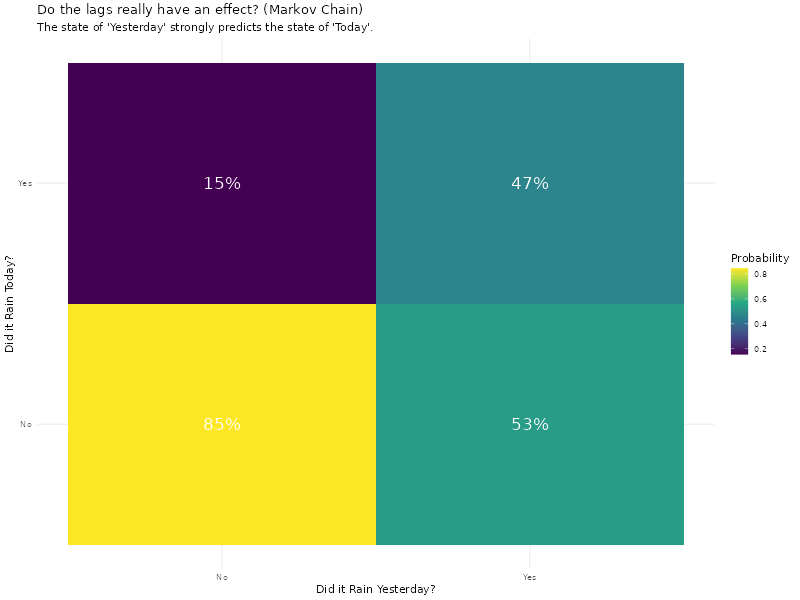

In [21]:
# Does it matter to know if it rained yesterday to predict if it will rain today?
df_final %>%
  group_by(location) %>%
  arrange(date) %>%
  mutate(yesterday_rain = lag(rain_today)) %>%
  ungroup() %>%
  
  # Remove NA introduced by lags
  filter(!is.na(rain_today), !is.na(yesterday_rain)) %>%
  count(yesterday_rain, rain_today) %>%
  group_by(yesterday_rain) %>%
  mutate(prob = n / sum(n)) %>%

  ggplot(aes(x = yesterday_rain, y = rain_today, fill = prob)) +
  geom_tile() +
  geom_text(aes(label = scales::percent(prob, accuracy = 1)), color = "white", size = 6) +
  scale_fill_viridis_c() +
  labs(
    title = "Do the lags really have an effect? (Markov Chain)",
    subtitle = "The state of 'Yesterday' strongly predicts the state of 'Today'.",
    x = "Did it Rain Yesterday?",
    y = "Did it Rain Today?",
    fill = "Probability"
  ) +
  theme_minimal()

Well it does, if it rained yesterday, then there is an 85% chance it wont rain today, if it rained yesterday its almost a coin toss it will rain today but the probability of raining triples if it did rain yesterday.

Warning message:
In geom_density2d_filled(continuous_var = "ndensity", bins = 7) :
  Ignoring unknown parameters: `continuous_var`


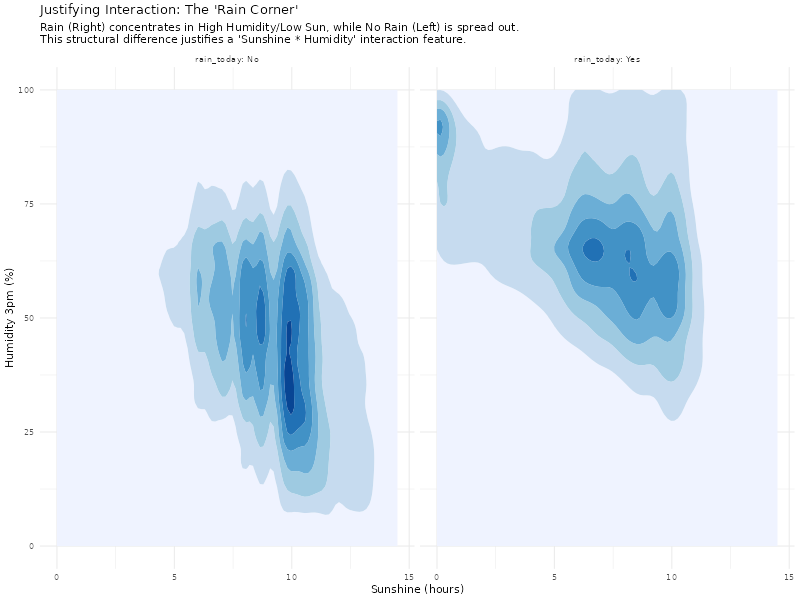

In [22]:
df_final %>% 
  group_by(location) %>% 
  arrange(date) %>% 
  mutate(
    days_since_rain = {
        rain_days <- which(rainfall > 0)
        sapply(seq_along(rainfall), function(i) {
          prev_rain <- rain_days[rain_days < i]
          if(length(prev_rain) == 0) NA_integer_
          else i - max(prev_rain)
        })
      }
  ) %>% 
  ggplot(aes(sunshine, humidity3pm)) +
  geom_density2d_filled(continuous_var = "ndensity", bins = 7) +
  facet_wrap(~rain_today, labeller = label_both) +
  scale_fill_brewer(palette = "Blues") +
  labs(
    title = "Justifying Interaction: The 'Rain Corner'",
    subtitle = "Rain (Right) concentrates in High Humidity/Low Sun, while No Rain (Left) is spread out.\nThis structural difference justifies a 'Sunshine * Humidity' interaction feature.",
    x = "Sunshine (hours)",
    y = "Humidity 3pm (%)"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

There exists a non linear, conditional relationship with rainfall. the no rain class shows a broad distribution, indicating a high humidity alone doesnt guarantee precipitation if enough sunshine is present. The rain class is confined to a specific corner of the feature space, the intersecion of low sunshine and high humidity

This then demonstrates that the effect on rainfall probability is conditional on the level of sunshine, so we should add an interaction term between the two

Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once per session.
Call ]8;;x-r-run:lifecycle::last_lifecycle_warnings()lifecycle::last_lifecycle_warnings()]8;; to see where this warning was
generated. 


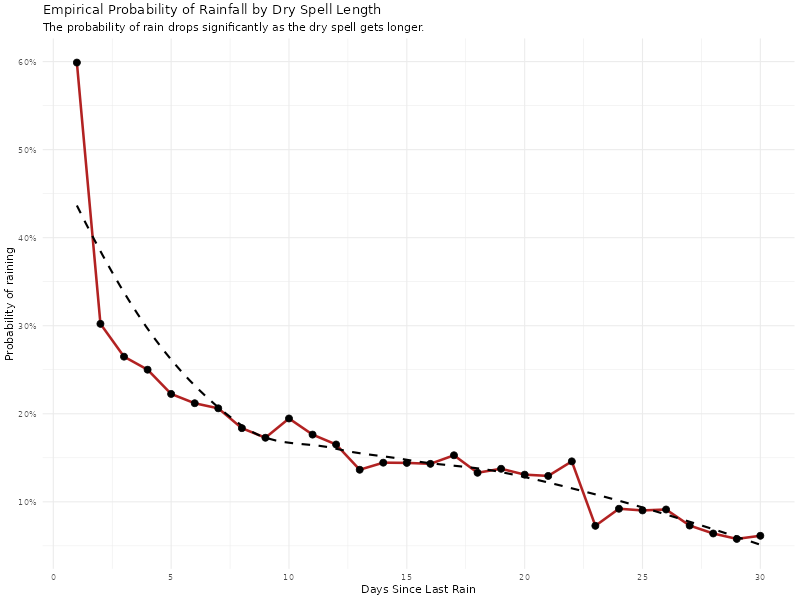

`geom_smooth()` using formula = 'y ~ x'

In [23]:
df_final %>% 
  group_by(location) %>% 
  arrange(date) %>% 
  mutate(
    did_rain_yesterday = lag(rainfall > 0, default = FALSE) ,
    dry_spell_id = cumsum(did_rain_yesterday)
  ) %>% 
  group_by(location, dry_spell_id) %>% 
  # Count days weve been in this dry spell
  mutate(days_since_rain = row_number()) %>% 
  ungroup() %>% 
  filter(days_since_rain <= 30) %>%
  group_by(days_since_rain) %>%
  summarise(prob_rain = mean(rainfall > 0, na.rm = TRUE)) %>%
  ggplot(aes(x = days_since_rain, y = prob_rain)) +
  geom_line(color = "firebrick", size = 1.2) +
  geom_point(size = 3) +
  geom_smooth(method = "loess", se = FALSE, color = "black", linetype = "dashed") +
  scale_y_continuous(labels = scales::percent_format(1),
                    breaks = pretty_breaks(n = 6)) +
  scale_x_continuous(breaks = scales::pretty_breaks()) +
  labs(x = "Days Since Last Rain", 
       y = "Probability of raining", 
       subtitle = "The probability of rain drops significantly as the dry spell gets longer.",
       title = "Empirical Probability of Rainfall by Dry Spell Length") +
  theme_minimal()

The probability of rainfall exhibits strong state dependence based on the duration of the preceding dry spell. the empirical probability f precipitation follows a non linear decay function relative to the nummber of days since the last rainfall event. The probability of rain at day 1 is 60%, it drops sharply to 10 percent at day 25, this is an indication that rainfall occurrence are not Poisson events. we need to make days_since_rain feature to mode the thermodynamic barrier, where longer dry spells impose statisticaly higher thresholds for generating new precipitation.

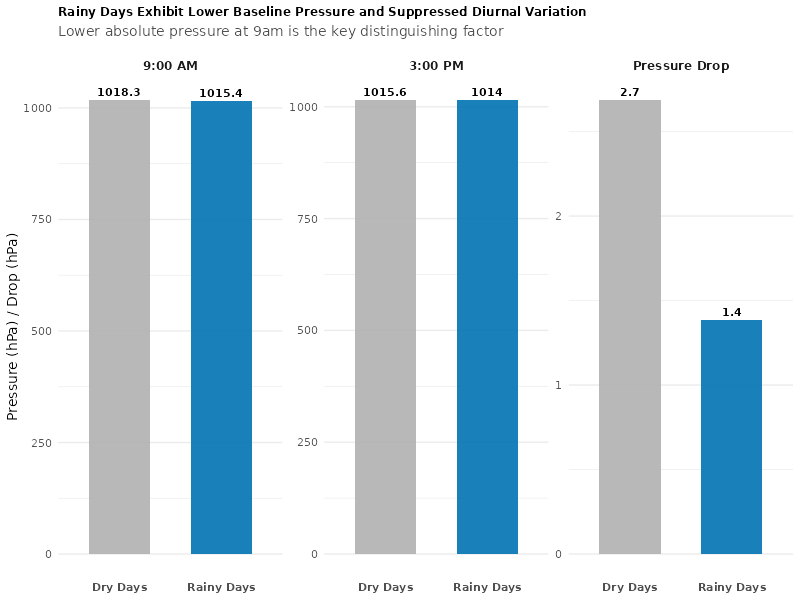

In [24]:
# Analyze the pressure change
data_wide <- df_final %>% 
  group_by(rain_today) %>% 
  summarise(
    `9:00 AM` = mean(pressure9am, na.rm = TRUE),
    `3:00 PM` = mean(pressure3pm, na.rm = TRUE),
    `Pressure Drop` = mean(pressure9am, na.rm = TRUE) - mean(pressure3pm, na.rm = TRUE)
  ) %>% 
  pivot_longer(cols = -rain_today, names_to = "metric", values_to = "value") %>% 
  mutate(
    metric = factor(metric, levels = c("9:00 AM", "3:00 PM", "Pressure Drop")),
    label_txt = round(value, 1)
  )

ggplot(data_wide, aes(x = rain_today, y = value, fill = rain_today)) +
  geom_col(width = 0.6, alpha = 0.9) +
  geom_text(aes(label = label_txt), vjust = -0.5, fontface = "bold", size = 4) +
  facet_wrap(~metric, scales = "free_y", nrow = 1) +
  
  scale_fill_manual(values = c("No" = "#B0B0B0", "Yes" = "#0072B2")) +
  scale_x_discrete(labels = c("No" = "Dry Days", "Yes" = "Rainy Days")) +
  
  labs(
    title = "Rainy Days Exhibit Lower Baseline Pressure and Suppressed Diurnal Variation",
    subtitle = "Lower absolute pressure at 9am is the key distinguishing factor",
    y = "Pressure (hPa) / Drop (hPa)",
    x = NULL
  ) +
  
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "none",
    plot.title = element_text(face = "bold", size = 12),
    plot.subtitle = element_text(color = "grey30", margin = margin(b = 15)),
    axis.text.x = element_text(face = "bold", size = 11),
    strip.text = element_text(face = "bold", size = 12),
    panel.grid.major.x = element_blank()
  )


In [25]:
df_final %>% 
  mutate(pressure_change = pressure3pm - pressure9am) %>% 
  rstatix::cohens_d(pressure_change ~ rain_today)

# A tibble: 1 × 7
  .y.             group1 group2 effsize     n1    n2 magnitude
* <chr>           <chr>  <chr>    <dbl>  <int> <int> <ord>    
1 pressure_change No     Yes     -0.676 110319 31880 moderate 

We analyze the structural differences in diurnal pressure variation. dry days show a stronger diurnal tide driven by solar heating, whereas rainy days show a surpressed decline due to cloud insulation.
statistical analysis confirms the magnitude of this separation. despite the absolute difference being small (~1.3hPa), the standardized effect size is substantial (Cohen's d = -.68). This moderate effect confirms that the suppression of the diurnal drop is a robust physical signal for precipitation, distinct from the absolute pressure baseline.

In [26]:
df_final %>% 
  filter(rainfall > 0) %>% 
  group_by(month) %>% 
  summarise(median_rain = median(rainfall),
            mean_rain = mean(rainfall),
            rain_days = n(),
          .groups = "drop") %>% 
  mutate(month_label = factor(month.abb[month], levels = rev(month.abb))) -> monthly_stats

df_final %>% 
  filter(rainfall > 0) %>% 
  mutate(
    month_label = factor(month.abb[month], levels = rev(month.abb)),
    log_rain = log(rainfall)
  ) %>% 
  left_join(monthly_stats, by = c("month", "month_label")) -> plot_data



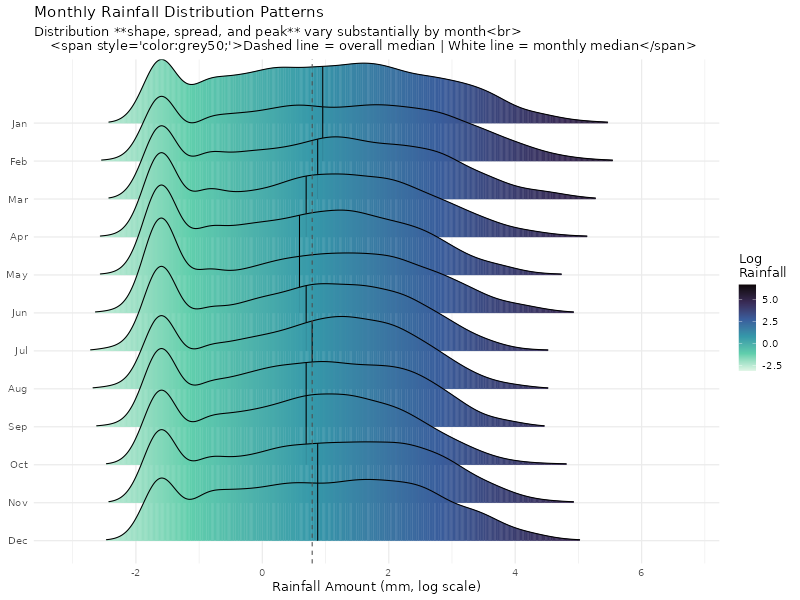

Picking joint bandwidth of 0.273

In [27]:
library(ggridges)
ggplot(plot_data, aes(log_rain, month_label, fill = after_stat(x))) +
  geom_density_ridges_gradient(    
    scale = 2.5, 
    rel_min_height = 0.01,
    quantile_lines = TRUE,
    quantiles = 2,  # Show median line
    alpha = 0.8
  ) +
  # Add the global median
  geom_vline(xintercept = median(log(df_final$rainfall[df_final$rainfall > 0])),
             linetype = "dashed", color = "grey30", linewidth = 0.5) +
  scale_fill_viridis_c(
    option = "mako", 
    name = "Log\nRainfall",
    direction = -1
  ) +
  scale_x_continuous(breaks = pretty_breaks()) +
  labs(
    title = "Monthly Rainfall Distribution Patterns",
    subtitle = "Distribution **shape, spread, and peak** vary substantially by month<br>
    <span style='color:grey50;'>Dashed line = overall median | White line = monthly median</span>",
    x = "Rainfall Amount (mm, log scale)",
    y = NULL,
  ) +
  
  theme_minimal(base_size = 13)

In [28]:
# Check rainfall seasonality
df_final %>% 
  filter(rainfall > 0) %>% 
  mutate(
    season = case_when(
      month %in% c(12, 1, 2) ~ "Summer",
      month %in% c(3, 4, 5) ~ "Autumn",
      month %in% c(6, 7, 8) ~ "Winter",
      month %in% c(9, 10, 11) ~ "Spring"
    ),
    season = factor(season, levels = c("Summer", "Autumn", "Winter", "Spring")),
    month_label = factor(month.abb[month], levels = month.abb)
  ) -> plot_data_seasonal



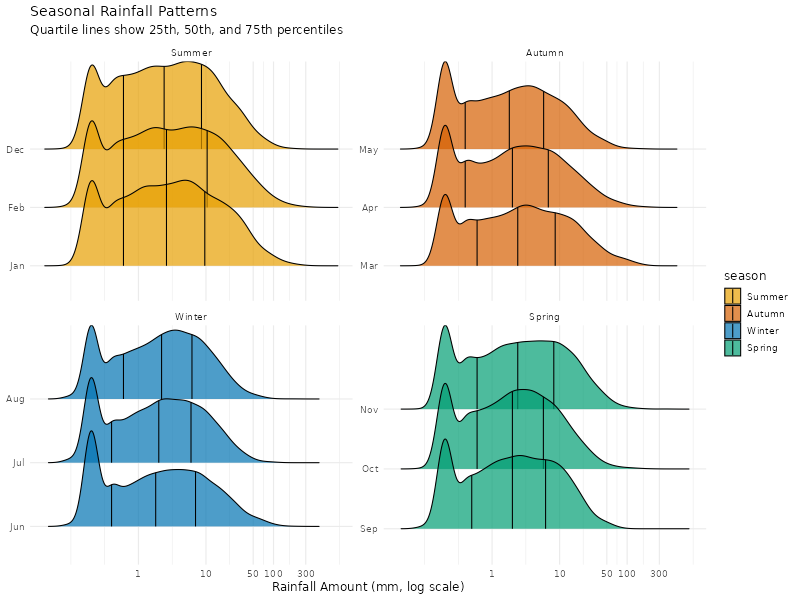

Picking joint bandwidth of 0.129
Picking joint bandwidth of 0.119
Picking joint bandwidth of 0.111
Picking joint bandwidth of 0.116

In [29]:
ggplot(plot_data_seasonal, aes(rainfall, month_label, fill = season)) +
  geom_density_ridges(
    scale = 1.5,
    alpha = 0.7,
    quantile_lines = TRUE,
    quantiles = c(0.25, 0.5, 0.75)
  ) +
  scale_x_log10(
                breaks = c(1, 10, 50, 100, 300),
                labels = label_number(accuracy = 1)) +
  scale_fill_manual(
    values = c("Summer" = "#E69F00", "Autumn" = "#D55E00", 
               "Winter" = "#0072B2", "Spring" = "#009E73")
  ) +
  facet_wrap(~season, scales = "free_y", ncol = 2) +
  labs(
    title = "Seasonal Rainfall Patterns",
    subtitle = "Quartile lines show 25th, 50th, and 75th percentiles",
    x = "Rainfall Amount (mm, log scale)",
    y = NULL
  ) +
  
  theme_minimal(base_size = 12)

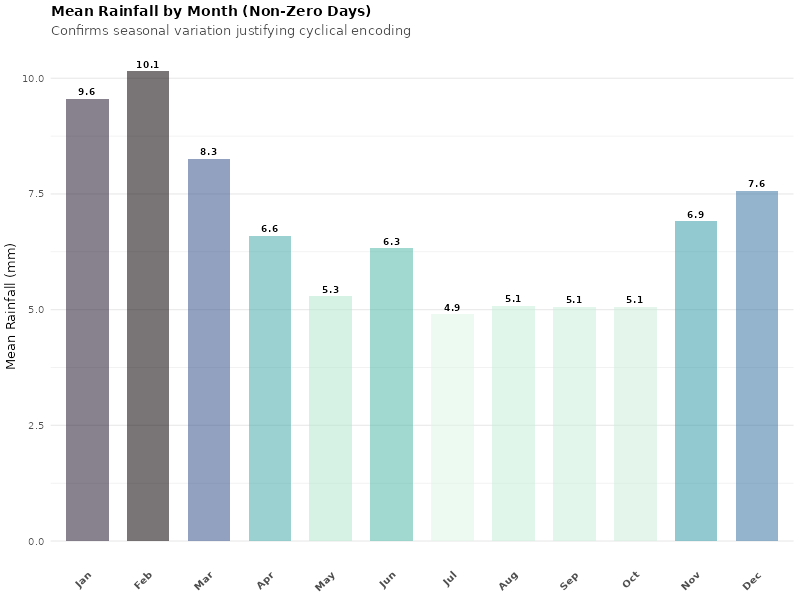

In [39]:
# Is there a sign of seasonal variation in rainfall patterns?
monthly_stats %>% 
  mutate(
    month_label = factor(month.abb[month], levels = month.abb)
  ) %>% 
    ggplot(aes(month_label, mean_rain)) +
    geom_col(aes(fill = mean_rain, alpha = 0.8, width = 0.7)) +
    geom_text(aes(label = round(mean_rain, 1)), 
            vjust = -0.5, size = 3.5, fontface = "bold") +
    scale_fill_viridis_c(option = "mako", direction = -1) +
    labs(
      title = "Mean Rainfall by Month (Non-Zero Days)",
      subtitle = "Confirms seasonal variation justifying cyclical encoding",
      y = "Mean Rainfall (mm)",
      x = NULL
    ) +
    theme_minimal(base_size = 13) +
    theme(
      plot.title = element_text(face = "bold", size = 14),
      plot.subtitle = element_text(color = "grey30", margin = margin(b = 10)),
      legend.position = "none",
      panel.grid.major.x = element_blank(),
      axis.text.x = element_text(angle = 45, hjust = 1, face = "bold")
    )

In [48]:
# Moving Averages Analysis

ma_data <- df_final %>% 
  group_by(location) %>% 
  arrange(date) %>% 
  mutate(
    rainfall_ma3 = rollmean(rainfall, k = 3, fill = NA, align = "right"),
    rainfall_ma7 = rollmean(rainfall, k = 7, fill = NA, align = "right"),
    humidity_ma3 = rollmean(humidity3pm, k = 3, fill = NA, align = "right"),
    humidity_ma3 = rollmean(humidity3pm, k = 7, fill = NA, align = "right"),
  ) %>% 
  ungroup()


In [ ]:
p1_data <- ma_data %>% 
  filter(rainfall > 0) %>% 
  select(rainfall, rainfall_ma3, rainfall_ma7) %>% 
  pivot_longer(everything(), names_to = "metric", values_to = "value") %>% 
  filter(!is.na(value)) %>% 
  mutate(
    metric = factor(metric, 
                    levels = c("rainfall", "rainfall_ma3", "rainfall_ma7"),
                    labels = c("Raw Daily", "3-Day MA", "7-Day MA")))



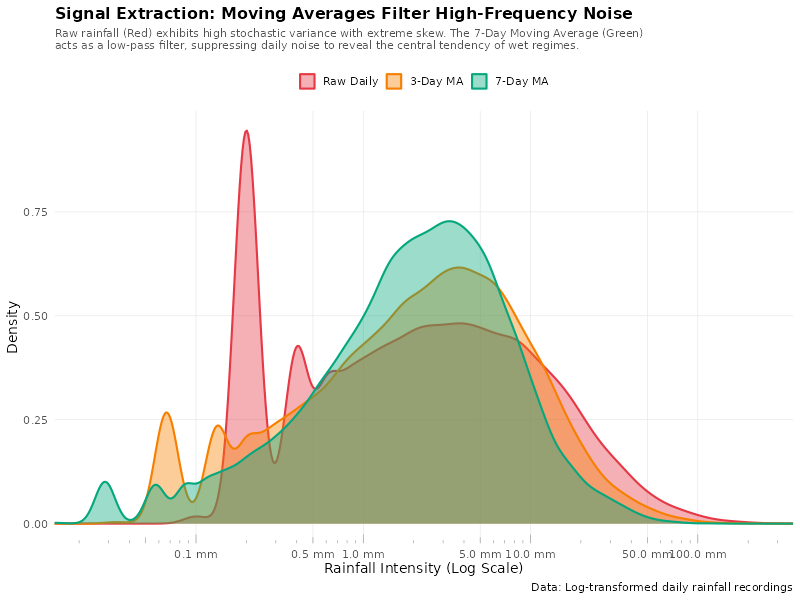

In [58]:
ggplot(p1_data, aes(x = value, fill = metric, color = metric)) +
  geom_density(alpha = 0.4, linewidth = 1) +
  annotation_logticks(sides = "b", color = "grey60", linewidth= 0.3) + 
  scale_x_log10(
    breaks = c(0.1, 0.5, 1, 5, 10, 50, 100), 
    labels = label_number(suffix = " mm"),
    expand = c(0, 0)
  ) +
  
  scale_fill_manual(
    values = c("Raw Daily" = "#E63946", "3-Day MA" = "#F77F00", "7-Day MA" = "#06A77D")
  ) +
  scale_color_manual(
    values = c("Raw Daily" = "#E63946", "3-Day MA" = "#F77F00", "7-Day MA" = "#06A77D")
  ) +
  labs(
    title = "Signal Extraction: Moving Averages Filter High-Frequency Noise",
    subtitle = "Raw rainfall (Red) exhibits high stochastic variance with extreme skew. The 7-Day Moving Average (Green)\nacts as a low-pass filter, suppressing daily noise to reveal the central tendency of wet regimes.",
    x = "Rainfall Intensity (Log Scale)",
    y = "Density",
    caption = "Data: Log-transformed daily rainfall recordings",
    fill = NULL,
    color = NULL
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "top",
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_line(color = "grey90", size = 0.3),
    panel.grid.major.y = element_line(color = "grey90", size = 0.3),
    plot.title = element_text(face = "bold", size = 16),
    plot.subtitle = element_text(color = "grey30", size = 11, margin = margin(b = 15)),
    axis.text.x = element_text(margin = margin(t = 5))
  )

# Trim the columns


In [22]:

vif_check <- lm(rainfall ~ ., data = df_final)
check_collinearity(vif_check)

Model matrix is rank deficient. VIFs may not be sensible.


# Check for Multicollinearity

Low Correlation

                 Term  VIF           VIF 95% CI adj. VIF Tolerance
                 date 1.24 [    1.23,     1.25]     1.11      0.81
          evaporation 2.37 [    2.35,     2.39]     1.54      0.42
      wind_gust_speed 2.73 [    2.71,     2.76]     1.65      0.37
        wind_speed9am 2.16 [    2.14,     2.18]     1.47      0.46
        wind_speed3pm 2.30 [    2.28,     2.31]     1.52      0.44
          humidity9am 4.61 [    4.57,     4.66]     2.15      0.22
             cloud3pm 4.02 [    3.99,     4.06]     2.01      0.25
           rain_today 1.43 [    1.42,     1.44]     1.20      0.70
                  day 1.03 [    1.02,     1.04]     1.00      0.97
 cloud3pm_imp_flagged 4.06 [    4.03,     4.10]     2.02      0.25
    cloud_development 3.30 [    3.28,     3.33]     1.82      0.30
 Tolerance 95% CI
     [0.80, 0.81]
     [0.42, 0.43]
     [0.36, 0.37]
     [0.46, 0.47]
     [0.43, 0.44]
     [0.21, 0.22]
     [0.25, 0.25]
    

In [ ]:
df_clean <- df_clean %>% 
  select(-c(min_temp, temp9am, temp3pm, pressure9am, wind_dir3pm,
            wind_dir9am, location, date, rain_tomorrow,
            sunshine, evaporation, cloud3pm, cloud9am))

In [22]:

m1_zigamma <- glmmTMB(
  rainfall ~ max_temp + wind_gust_speed + humidity3pm + pressure3pm + rain_today + month,
  ziformula = ~ humidity3pm + pressure3pm + month, 
  data = df_clean,
  family = ziGamma(link = "log")
)

summary(m1_zigamma)

 Family: Gamma  ( log )
Formula:          
rainfall ~ max_temp + wind_gust_speed + humidity3pm + pressure3pm +  
    rain_today + month
Zero inflation:            ~humidity3pm + pressure3pm + month
Data: df_clean

      AIC       BIC    logLik -2*log(L)  df.resid 
 308357.1  308667.5 -154146.5  308293.1    120851 


Dispersion estimate for Gamma family (sigma^2): 0.707 

Conditional model:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      8.8120567  0.6621234    13.3  < 2e-16 ***
max_temp         0.0192311  0.0010079    19.1  < 2e-16 ***
wind_gust_speed  0.0084532  0.0003088    27.4  < 2e-16 ***
humidity3pm      0.0128827  0.0002545    50.6  < 2e-16 ***
pressure3pm     -0.0108645  0.0006401   -17.0  < 2e-16 ***
rain_todayYes    2.8902092  0.0091246   316.8  < 2e-16 ***
month2           0.0700942  0.0221127     3.2  0.00153 ** 
month3           0.0023127  0.0205786     0.1  0.91052    
month4          -0.0523097  0.0217401    -2.4  0.01612 *  
month5          -

In [ ]:
# Generate and visualize predictions

In [ ]:
# use tweedie glmmTMB instead of the hurdle zigamma


In [ ]:
# Use GAM with tweedie to capture non linear relationships

In [ ]:
# Statistical model comparison (AIC x BIC) 

In [ ]:
# Diagnose the GAM using Dharma

In [ ]:
# Bayesian Inference?